In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymysql
from sqlalchemy import create_engine
import time
from sklearn.preprocessing import StandardScaler, normalize, RobustScaler, MinMaxScaler, FunctionTransformer
from scipy.stats import boxcox
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hc
from sklearn.cluster import AgglomerativeClustering
from haversine import haversine, Unit


In [2]:
con = pymysql.connect(host='localhost', user='jiwoo', password='1234', db='TESTDB', charset='utf8', autocommit=True, cursorclass=pymysql.cursors.DictCursor)
cur = con.cursor()
sql = "SELECT pk, 시도, 시군구, complex_name, official_price, 경도, 위도, closest_sub, closest_high, school_1km, area, floor, actual FROM off_act_price WHERE 시도='인천광역시'"
cur.execute(sql)
rows = cur.fetchall()
con.close()

In [3]:
gangwon = pd.DataFrame(rows)

In [4]:
real_trainInfo = gangwon.dropna(subset='actual')
needPredict = gangwon[gangwon['actual'].isnull()==True]

X = real_trainInfo.drop('actual', axis=1)
y = real_trainInfo['actual']

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [7]:
train_pk = x_train[['pk', 'complex_name', '시군구']]
valid_pk = x_valid[['pk', 'complex_name', '시군구']]
test_pk = X_test[['pk', 'complex_name', '시군구']]
predict_pk = needPredict[['pk', 'complex_name', '시군구']]

train_data = x_train.join(y_train)
train_data['floor'] = train_data['floor']+2
needPredict['floor'] = needPredict['floor']+2
#train_data['1km내sub수+'] = train_data['1km내sub수']+2
train_data['school_1km'] = train_data['school_1km']+2
needPredict['school_1km'] = needPredict['school_1km']+2

<ipython-input-7-71bc357cbf46>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  needPredict['floor'] = needPredict['floor']+2
<ipython-input-7-71bc357cbf46>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  needPredict['school_1km'] = needPredict['school_1km']+2


In [8]:
from scipy.stats import boxcox
#train_data['area'] = train_data['area'].apply(lambda x: boxcox(x)[0])
train_data[['school_1km', 'area']] = np.sqrt(train_data[['school_1km', 'area']])
train_data[['actual','floor', 'official_price', 'closest_sub', 'closest_high']] = np.log(train_data[['actual','floor', 'official_price', 'closest_sub', 'closest_high']])
#needPredict['area'] = needPredict['area'].apply(lambda x: boxcox(x)[0])
needPredict[['school_1km', 'area']] = np.sqrt(needPredict[['school_1km', 'area']])
needPredict[['floor', 'official_price', 'closest_sub', 'closest_high']] = np.log(needPredict[['floor', 'official_price', 'closest_sub', 'closest_high']])

<ipython-input-8-667390977756>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  needPredict[['school_1km', 'area']] = np.sqrt(needPredict[['school_1km', 'area']])
<ipython-input-8-667390977756>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  needPredict[['floor', 'official_price', 'closest_sub', 'closest_high']] = np.log(needPredict[['floor', 'official_price', 'closest_sub', 'closest_high']])


In [9]:
realX = needPredict.drop(['actual', 'pk', '시도', 'complex_name', '시군구'], axis=1)

In [10]:
x_train, y_train = train_data.drop(['actual', 'pk', '시도', 'complex_name', '시군구'], axis=1), train_data['actual']

valid_data = x_valid.join(y_valid)

valid_data['floor'] = valid_data['floor']+2
#valid_data['1km내sub수+'] = valid_data['1km내sub수']+2
valid_data['school_1km'] = valid_data['school_1km']+2

In [11]:
valid_data[['school_1km', 'area']] = np.sqrt(valid_data[['school_1km', 'area']])
valid_data[['actual','floor', 'official_price', 'closest_sub', 'closest_high']] = np.log(valid_data[['actual','floor', 'official_price', 'closest_sub', 'closest_high']])

x_valid, y_valid = valid_data.drop(['actual', 'pk', '시도', 'complex_name', '시군구'], axis=1), valid_data['actual']

In [12]:
test_data = X_test.join(y_test)

test_data['floor'] = test_data['floor']+2
#valid_data['1km내sub수+'] = valid_data['1km내sub수']+2
test_data['school_1km'] = test_data['school_1km']+2

#valid_data['area'] = valid_data['area'].apply(lambda x: boxcox(x)[0])
test_data[['school_1km', 'area']] = np.sqrt(test_data[['school_1km', 'area']])
test_data[['actual_price','floor', 'official_price', 'closest_sub', 'closest_high']] = np.log(test_data[['actual','floor', 'official_price', 'closest_sub', 'closest_high']])

In [13]:
y_test_actual_price = test_data['actual']
X_test, y_test = test_data.drop(['actual', 'actual_price', 'pk', '시도', 'complex_name', '시군구'], axis=1), test_data['actual_price']

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_s = scaler.transform(x_train)
x_valid_s = scaler.transform(x_valid)
X_test_s = scaler.transform(X_test)

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

tree = DecisionTreeRegressor()
tree.fit(x_train_s, y_train)

treeScore = tree.score(X_test_s, y_test)

y_pred_train = tree.predict(x_train_s)

tree_R2 = r2_score(y_train, y_pred_train)
tree_mae = mean_absolute_error(y_train, y_pred_train)

y_pred_valid = tree.predict(x_valid_s)

tree_R2 = r2_score(y_valid, y_pred_valid)
tree_mae = mean_absolute_error(y_valid, y_pred_valid)

from sklearn.model_selection import cross_val_score
tree_scores = cross_val_score(tree, x_valid_s, y_valid, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

final_pred_tree = tree.predict(X_test_s)

from sklearn.metrics import mean_squared_error
final_mse_tree = mean_squared_error(y_test, final_pred_tree)
final_rmse_tree = np.sqrt(final_mse_tree)
final_r2_tree = r2_score(y_test, final_pred_tree)

needPredict_s = scaler.transform(realX)
finalPred = tree.predict(needPredict_s)
needPred_df = pd.DataFrame(finalPred, columns=['예측가격'])
needPred_df[['pk', 'complex_name', '시군구']] = predict_pk[['pk', 'complex_name', '시군구']].values
needPred_df['predicted_price'] = np.exp(needPred_df['예측가격'])
needPred_df.drop('예측가격', axis=1, inplace=True)

       predicted_price  actual_price          error
count     6.812710e+05  6.812710e+05  681271.000000
mean      2.714213e+08  2.752207e+08       1.364891
std       1.297830e+08  1.422281e+08      15.778586
min       3.200000e+07  3.200000e+07     -58.074140
25%       1.739857e+08  1.735000e+08      -6.665683
50%       2.532576e+08  2.490000e+08       3.164142
75%       3.400715e+08  3.450000e+08      11.588597
max       3.483253e+09  4.500000e+09     136.139630


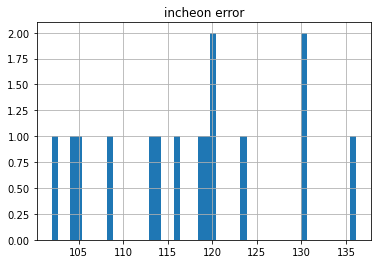

In [15]:
# 예측값
pred_tr = pd.DataFrame(final_pred_tree, columns=['예측가격'])
pred_tr[['pk', 'complex_name', '시군구']] = test_pk[['pk', 'complex_name', '시군구']].values
pred_tr['predicted_price'] = np.exp(pred_tr['예측가격'])
pred_tr['actual_price'] = y_test_actual_price.values
pred_tr['predicted_price'] = pred_tr['predicted_price'].astype(float)
# 결측치가 있는 것 같지는 않고 nan 이런 식으로 숫자가 아닌 데이터가 있는 듯. 확인해보기 바람
pred_tr.drop('예측가격', axis=1, inplace=True)
#pred_tr['predicted_price'] = pred_tr['predicted_price'].apply(lambda x: '{:.0f}'.format(x))
#jisang['codes'] = jisang['호str'].apply(lambda x: int(x) if x.isnumeric() else 0)

pred_tr['error'] = (pred_tr['predicted_price'] - pred_tr['actual_price']) / pred_tr['actual_price'] * 100
#check = pred_tr[(pred_tr['error']<-50)|(pred_tr['error']>50)]
check = pred_tr[(pred_tr['error']>100)]
print(pred_tr.describe())
check.describe()
check['error'].hist(bins=50)
plt.rc("axes", unicode_minus=False)
plt.rc('font', family='NanumGothic')
plt.title('incheon error')
plt.show()

In [18]:
check.describe()

,predicted_price,actual_price,error
count,1.500000e+01,1.500000e+01,15.000000
mean,7.387807e+08,3.416667e+08,117.422292
std,5.507233e+08,2.579465e+08,10.061742
min,1.329380e+08,6.500000e+07,101.980198
25%,2.102319e+08,9.400000e+07,110.781779
50%,7.900000e+08,3.600000e+08,118.487395
75%,1.217583e+09,5.690000e+08,121.651687
max,1.759545e+09,8.450000e+08,136.139630


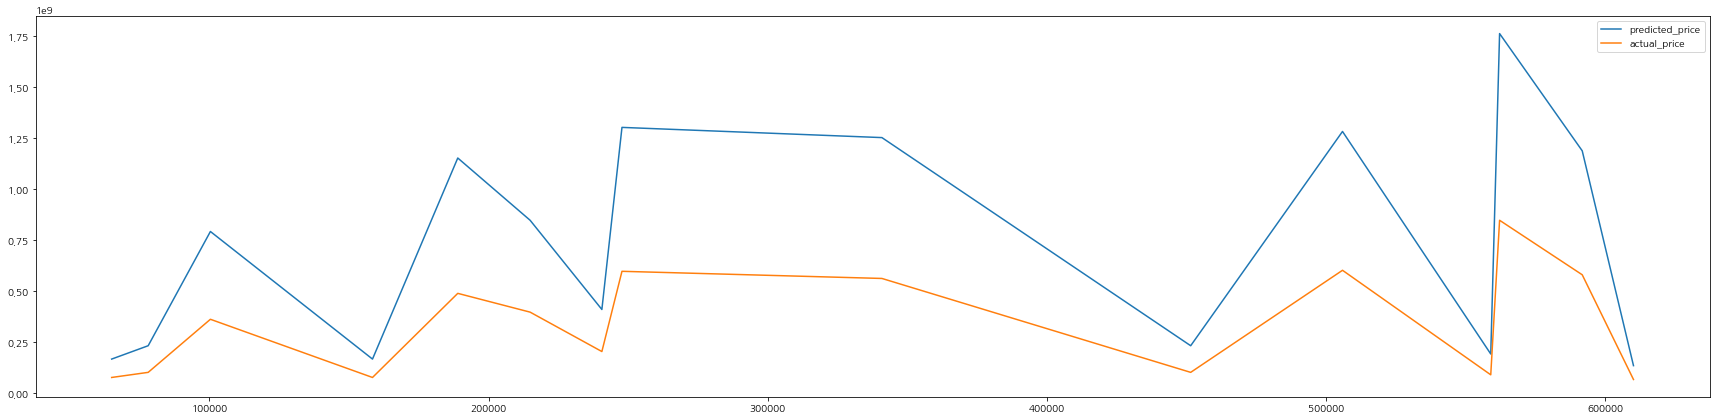

In [19]:
test_df = pred_tr[['pk', 'predicted_price']]
total_df = pd.concat([needPred_df, test_df])


final_tr = check[['predicted_price', 'actual_price']]

final_tr.iloc[0:20, :].plot(figsize=(30,7))
plt.show()


In [20]:
check

,pk,complex_name,시군구,predicted_price,actual_price,error
65050,00005472_0002_0017,삼부,동구,1.650668e+08,75000000.0,120.089088
78128,00005651_0002_0028,광명,부평구,2.304638e+08,100000000.0,130.463838
100410,20009226_0005_0051,송도풍림아이원2단지,연수구,7.900000e+08,360000000.0,119.444444
158455,00005472_0002_0011,삼부,동구,1.650668e+08,75000000.0,120.089088
188992,20116346_0004_0089,더샵퍼스트월드,연수구,1.150000e+09,487000000.0,136.139630
214901,20376353_0001_0050,송도아메리칸타운아이파크,연수구,8.450000e+08,395000000.0,113.924051
240596,00009062_0001_0017,태평1차,남동구,4.080000e+08,202000000.0,101.980198
247793,20174554_0004_0138,청라더샵레이크파크,서구,1.300000e+09,595000000.0,118.487395
340880,20376353_0003_0045,송도아메리칸타운아이파크,연수구,1.250000e+09,560000000.0,123.214286
451453,00005651_0002_0029,광명,부평구,2.304638e+08,100000000.0,130.463838
